# 소득소비 EDA


## 라이브러리 임포트


In [1]:
import os
import psycopg2
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv

In [2]:
# Warning 무시
warnings.filterwarnings('ignore', category=UserWarning)

# Seaborn 테마 설정
sns.set_theme(style='whitegrid')

# matplotlib 한글 폰트 설정
os.system('rm -rf ~/.cache/matplotlib')
os.system('fc-cache -fv')

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

/usr/share/fonts: caching, new cache contents: 0 fonts, 5 dirs
/usr/share/fonts/cMap: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap: caching, new cache contents: 0 fonts, 5 dirs
/usr/share/fonts/cmap/adobe-cns1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-gb1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-japan1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-japan2: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-korea1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/opentype: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/opentype/urw-base35: caching, new cache contents: 35 fonts, 0 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 4 dirs
/usr/share/fonts/truetype/dejavu: caching, new cache contents: 6 fonts, 0 dirs
/usr/share/fonts/truetype/droid: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts

## 데이터 불러오기


In [3]:
# 환경 변수 로드
load_dotenv()

# DB 구성 객체
DB_CONFIG = {
    'host': os.getenv('DB_HOST', 'localhost'),
    'port': os.getenv('DB_PORT', 5432),
    'database': os.getenv('DB_NAME', 'postgres'),
    'user': os.getenv('DB_USER', 'postgres'),
    'password': os.getenv('DB_PASSWORD', 'postgres')
}

In [4]:
conn = psycopg2.connect(
    host=DB_CONFIG['host'],
    port=DB_CONFIG['port'],
    database=DB_CONFIG['database'],
    user=DB_CONFIG['user'],
    password=DB_CONFIG['password'],
    client_encoding='UTF8'
)

if conn is None:
  print("Connection failed")

### 상권 소득소비 데이터 로드


In [5]:
df_origin_dong = pd.read_sql_query('SELECT * FROM position.seoul_biz_dist_dong_radius_500m', conn)
df_origin_inc_con = pd.read_sql_query('SELECT * FROM more.seoul_biz_dist_income_consumption', conn)

In [6]:
df_dong = pd.json_normalize(df_origin_dong['data'].tolist())
df_inc_con = pd.json_normalize(df_origin_inc_con['data'].tolist())

## 데이터 전처리


In [7]:
df_dong[['상권그룹', '구분', '상권']]

,상권그룹,구분,상권
0,강남역,비젠트리피케이션,강남역
1,강남역,비젠트리피케이션,강남역
2,강남역,비젠트리피케이션,역삼역
3,강남역,비젠트리피케이션,신논현역
4,강남역,비젠트리피케이션,국기원
...,...,...,...
564,용리단길,젠트리피케이션,삼각지역
565,용리단길,젠트리피케이션,삼각지역
566,용리단길,젠트리피케이션,삼각지역 3번
567,용리단길,젠트리피케이션,삼각지역 3번


In [8]:
df_inc_con.columns

Index(['연도분기', '상권구분코드', '상권구분', '상권코드', '상권', '월평균소득금액', '소득구간코드', '지출총금액',
       '식료품지출총금액', '의류신발지출총금액', '생활용품지출총금액', '의료비지출총금액', '교통지출총금액', '여가지출총금액',
       '문화지출총금액', '교육지출총금액', '유흥지출총금액'],
      dtype='object')

In [9]:
df_inc_con.isna().sum()

연도분기           0
상권구분코드         0
상권구분           0
상권코드           0
상권             0
월평균소득금액      174
소득구간코드       174
지출총금액        799
식료품지출총금액     799
의류신발지출총금액    799
생활용품지출총금액    799
의료비지출총금액     799
교통지출총금액      799
여가지출총금액      799
문화지출총금액      799
교육지출총금액      799
유흥지출총금액      799
dtype: int64

In [10]:
df = df_dong[['상권그룹', '구분', '상권']].merge(df_inc_con, left_on='상권', right_on='상권', how='right')

In [11]:
columns = [
    '월평균소득금액', '지출총금액', '식료품지출총금액', '의류신발지출총금액',
    '생활용품지출총금액', '의료비지출총금액', '교통지출총금액', '여가지출총금액',
    '문화지출총금액', '교육지출총금액', '유흥지출총금액'
]

for col in columns:
  df[col] = pd.to_numeric(df[col], errors='coerce')

In [12]:
df['구분'] = df['구분'].fillna('기본')

In [13]:
df['연도'] = df['연도분기'].astype(str).str[:4]

In [14]:
df.head()

,상권그룹,구분,상권,연도분기,상권구분코드,상권구분,상권코드,월평균소득금액,소득구간코드,지출총금액,식료품지출총금액,의류신발지출총금액,생활용품지출총금액,의료비지출총금액,교통지출총금액,여가지출총금액,문화지출총금액,교육지출총금액,유흥지출총금액,연도
0,NaN,기본,서울국제고등학교,20191,A,골목상권,3110020,2838790.0,06,1.893277e+09,452132567.0,252800465.0,124254004.0,230932468.0,243437040.0,68238981.0,71326707.0,354675459.0,95479489.0,2019
1,대학로(혜화역),젠트리피케이션,성균관대학교,20191,A,골목상권,3110021,3094492.0,07,1.062084e+09,242915806.0,149142873.0,64336647.0,128741468.0,119906366.0,38074560.0,43410868.0,217013206.0,58541737.0,2019
2,대학로(혜화역),젠트리피케이션,성균관대학교,20191,A,골목상권,3110021,3094492.0,07,1.062084e+09,242915806.0,149142873.0,64336647.0,128741468.0,119906366.0,38074560.0,43410868.0,217013206.0,58541737.0,2019
3,대학로(혜화역),젠트리피케이션,성균관대학교,20191,A,골목상권,3110021,3094492.0,07,1.062084e+09,242915806.0,149142873.0,64336647.0,128741468.0,119906366.0,38074560.0,43410868.0,217013206.0,58541737.0,2019
4,대학로(혜화역),젠트리피케이션,성균관대학교,20191,A,골목상권,3110021,3094492.0,07,1.062084e+09,242915806.0,149142873.0,64336647.0,128741468.0,119906366.0,38074560.0,43410868.0,217013206.0,58541737.0,2019


## 데이터 분석


### 젠, 비젠, 기본 비교


In [15]:
df[df['연도'] == '2024']['연도분기'].unique()

array(['20241', '20242', '20243'], dtype=object)

### 연도별 구분별 월평균소득금액 비교


- 20년 이후로 데이터 갱신 안됨
- 기본상권지보다 젠트리, 비젠트리 지역의 소득 금액 훨씬 높다


In [16]:
def line_plot(df, col):

  # 연도와 카테고리별 월_평균_소득_금액 평균 계산
  trend = df.groupby(['연도', '구분'])[col].mean().reset_index()

  # 라인 플롯 그리기
  plt.figure(figsize=(12, 6))
  sns.lineplot(data=trend, x='연도', y=col, hue='구분', marker='o')

  # 그래프 제목 및 라벨 설정
  plt.title(f'연도별 구분별 {col} 변화', fontsize=14)
  plt.xlabel('연도', fontsize=12)
  plt.ylabel('월평균소득금액', fontsize=12)
  plt.legend(title='구분', fontsize=10)
  plt.grid(True)
  plt.show()

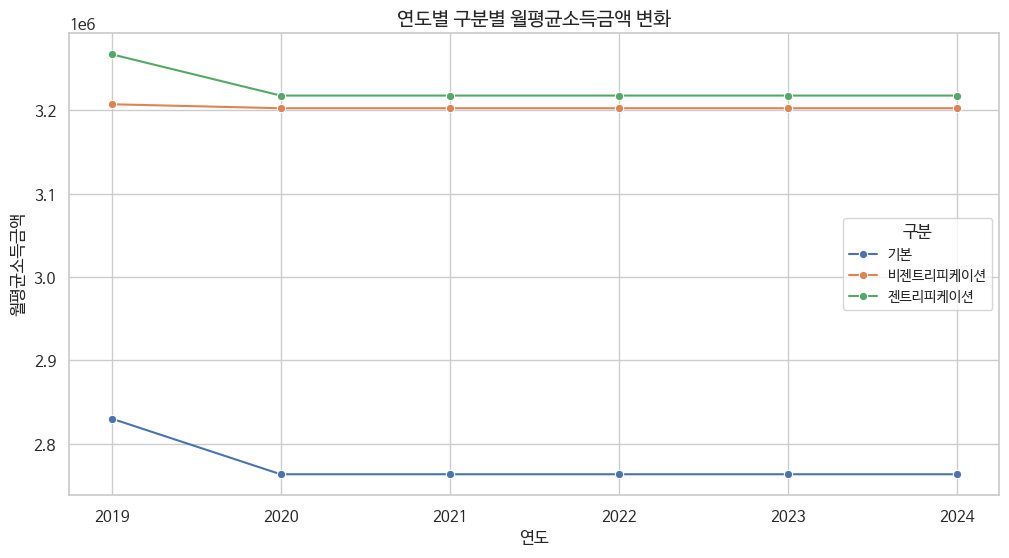

In [17]:
line_plot(df, '월평균소득금액')

### 연도별 카테고리별 지출총금액 비교


- 23년까지 데이터 갱신 안됨
- 비젠트리에서 지출총금액 가장 낮다
- 교통지출총금액, 문화지출총금액도 같은 양상


In [18]:
def plot_multiple_trends(df, columns):

  # 서브플롯 크기 설정 (3행 4열)
  fig, axes = plt.subplots(3, 4, figsize=(20, 15))
  axes = axes.flatten()  # 2D 배열을 1D 리스트로 변환

  for i, col in enumerate(columns):
    # 연도와 카테고리별 선택한 칼럼의 평균 계산
    trend = df.groupby(['연도', '구분'])[col].mean().reset_index()

    # 각 서브플롯에 라인 플롯 그리기
    sns.lineplot(data=trend, x='연도', y=col, hue='구분', marker='o', ax=axes[i])

    # 그래프 제목 및 라벨 설정
    axes[i].set_title(f'{col} 변화', fontsize=12)
    axes[i].set_xlabel('연도', fontsize=10)
    axes[i].set_ylabel(f'{col} 평균', fontsize=10)
    axes[i].legend(title='구분', fontsize=8)
    axes[i].grid(True)

  # 빈 플롯 숨기기 (칼럼 개수가 12 미만일 경우)
  for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

  # 서브플롯 간 간격 조정
  plt.tight_layout()
  plt.show()

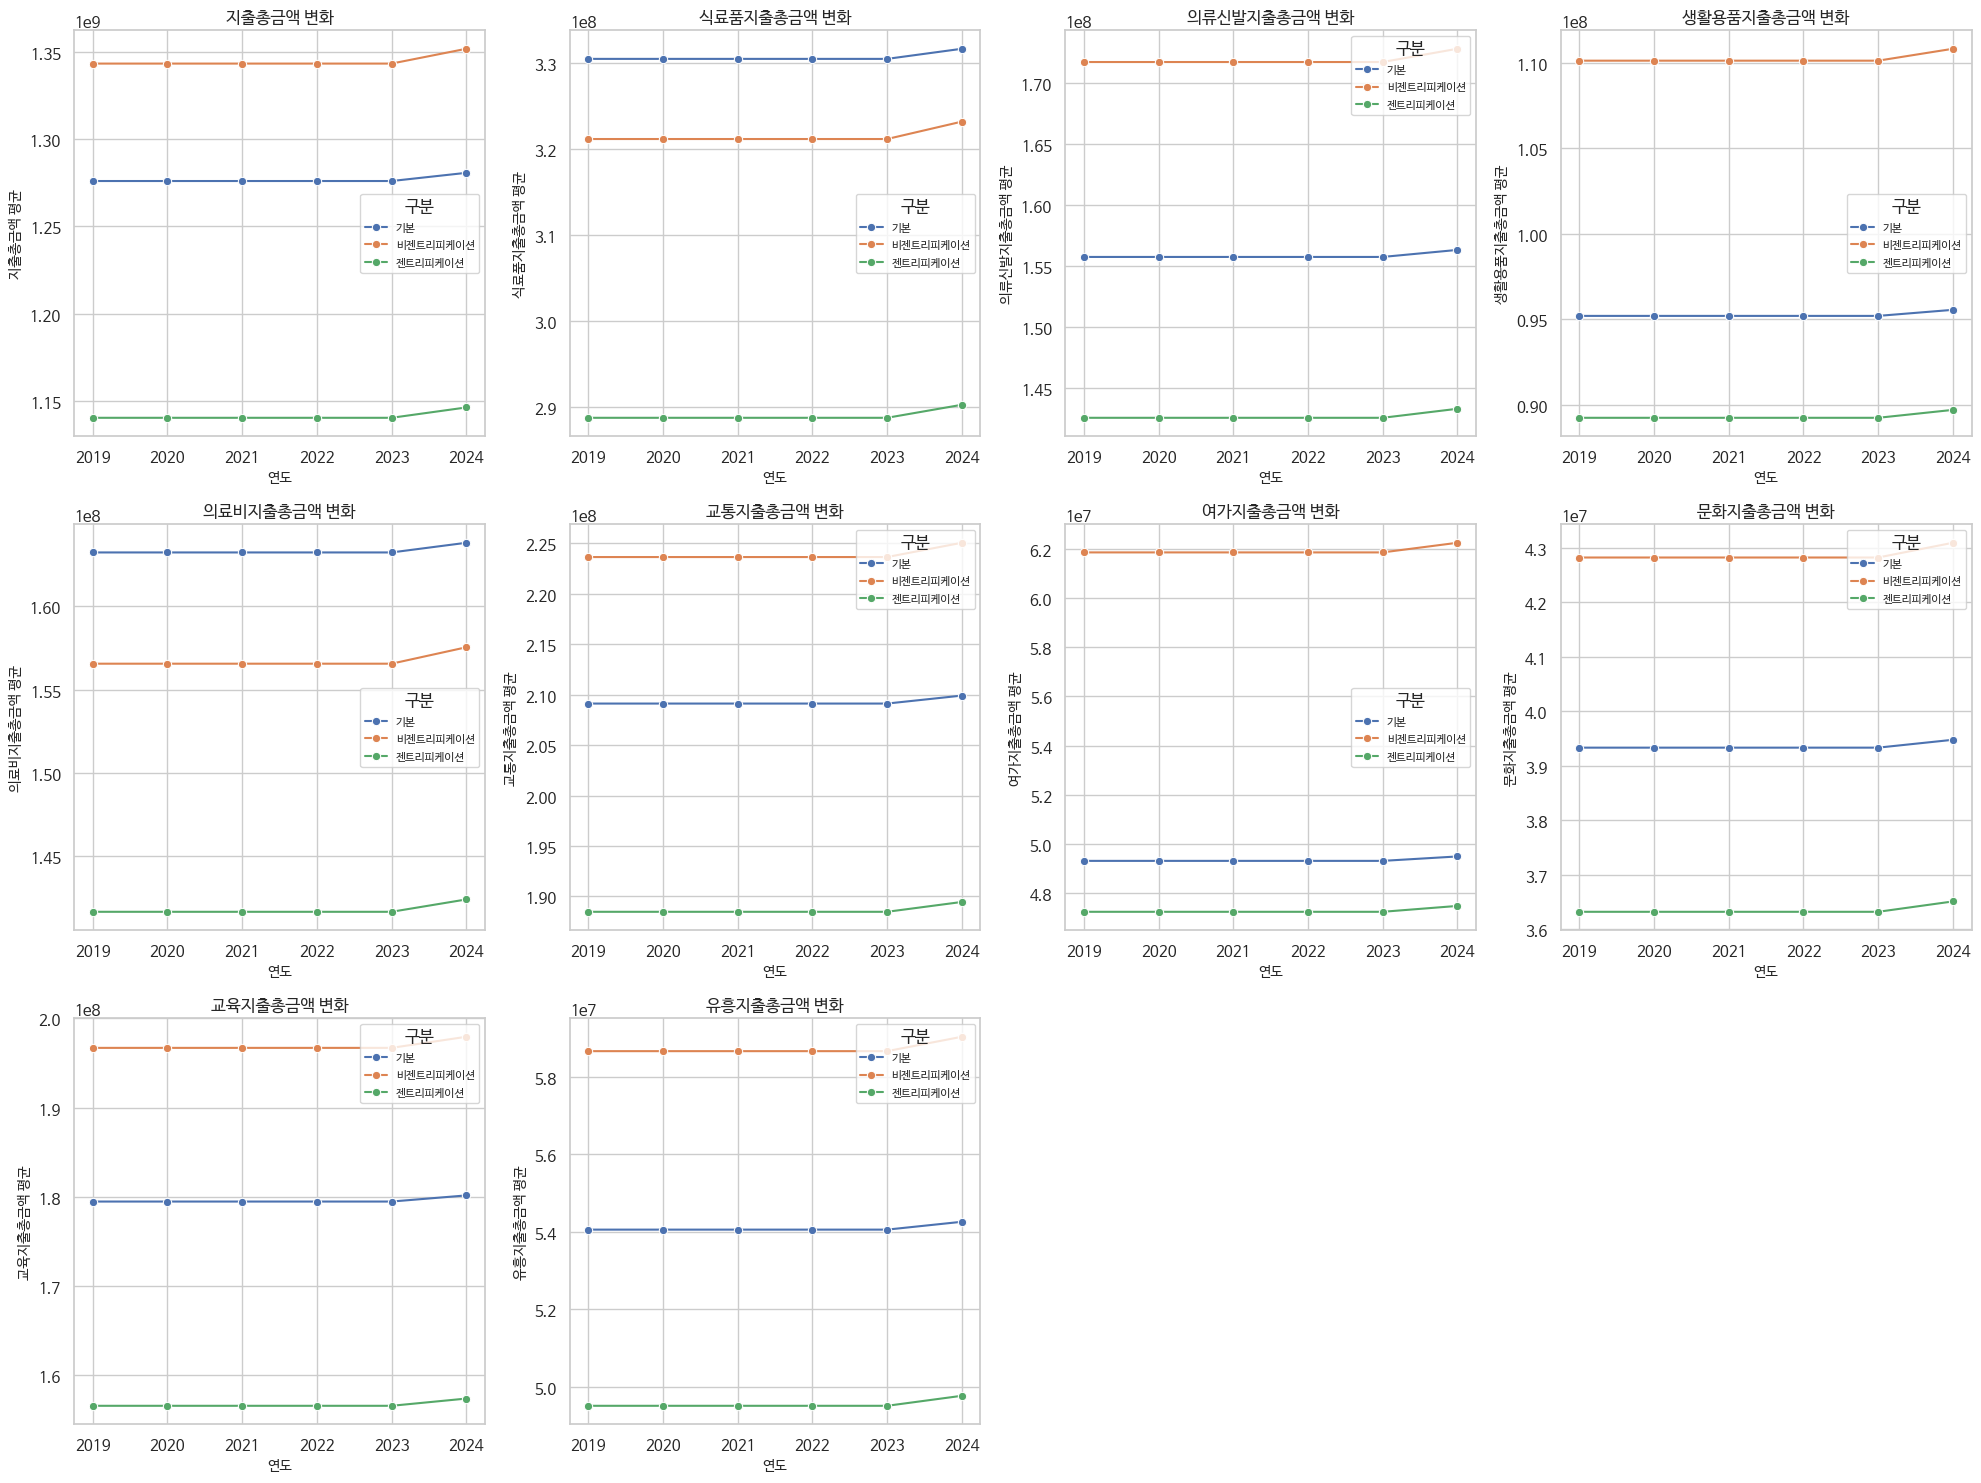

In [19]:
columns_to_visualize = [
    '지출총금액', '식료품지출총금액', '의류신발지출총금액',
    '생활용품지출총금액', '의료비지출총금액', '교통지출총금액', '여가지출총금액',
    '문화지출총금액', '교육지출총금액', '유흥지출총금액'
]

plot_multiple_trends(df, columns_to_visualize)

데이터 갱신이 잘 되지 않은 관계로 연도별 변화를 보는 것은 무의미하다고 판단


In [20]:
gen = df[df['구분'] == '젠트리피케이션']
non_gen = df[df['구분'] == '비젠트리피케이션']
normal = df[df['구분'] == '기본']

### 젠트리 내에서 월평균소득금액 높은 순으로 정렬


- 2019년과 2024년을 비교했을 때 순위 변동 크게 없다


In [21]:
gen[gen['연도'] == '2019'].groupby('상권그룹')['월평균소득금액'].mean().sort_values(ascending=False)

상권그룹
용리단길           4.294513e+06
서촌             4.182627e+06
신사동 가로수길       3.672010e+06
북촌             3.611803e+06
합정             3.430337e+06
경리단길           3.341343e+06
송리단길           3.199633e+06
명동             3.188011e+06
대학로(혜화역)       3.158630e+06
이수역            3.093722e+06
문래             3.008856e+06
홍대입구역          2.935572e+06
연남             2.924871e+06
종로3가           2.912050e+06
성수동            2.852721e+06
해방촌(이태원 근처)    2.805279e+06
신림             2.498322e+06
Name: 월평균소득금액, dtype: float64

In [22]:
gen[gen['연도'] == '2024'].groupby('상권그룹')['월평균소득금액'].mean().sort_values(ascending=False)

상권그룹
용리단길           4.219420e+06
서촌             4.057830e+06
신사동 가로수길       3.572555e+06
북촌             3.353606e+06
명동             3.237689e+06
합정             3.223871e+06
경리단길           3.187952e+06
송리단길           3.092524e+06
대학로(혜화역)       3.089551e+06
종로3가           3.072382e+06
이수역            2.978487e+06
문래             2.886851e+06
연남             2.848309e+06
홍대입구역          2.820550e+06
해방촌(이태원 근처)    2.760386e+06
성수동            2.711230e+06
신림             2.412861e+06
Name: 월평균소득금액, dtype: float64

### 젠트리 내에서 지출총금액 높은 순으로 정렬


In [23]:
gen[gen['연도'] == '2019'].groupby('상권그룹')['지출총금액'].mean().sort_values(ascending=False)

상권그룹
송리단길           3.608579e+09
경리단길           2.031863e+09
합정             1.951369e+09
신림             1.905167e+09
연남             1.878511e+09
홍대입구역          1.798879e+09
해방촌(이태원 근처)    1.699948e+09
신사동 가로수길       1.537914e+09
이수역            1.389185e+09
성수동            1.161684e+09
대학로(혜화역)       1.085170e+09
서촌             1.044885e+09
용리단길           9.050140e+08
북촌             8.800554e+08
문래             8.126490e+08
종로3가           5.877793e+08
명동             5.302101e+08
Name: 지출총금액, dtype: float64

### 비젠트리내에서 정렬


In [24]:
non_gen[non_gen['연도'] == '2019'].groupby('상권그룹')['월평균소득금액'].mean().sort_values(ascending=False)

상권그룹
여의도역        6.341916e+06
잠실역         5.124064e+06
청담          4.821512e+06
압구정로데오      4.087903e+06
강남역         4.032081e+06
동대문(DDP)    3.178664e+06
사당          3.121236e+06
회기역         2.764884e+06
영등포         2.636869e+06
건대입구역       2.553422e+06
Name: 월평균소득금액, dtype: float64

In [25]:
non_gen[non_gen['연도'] == '2019'].groupby('상권그룹')['지출총금액'].mean().sort_values(ascending=False)

상권그룹
잠실역         7.966035e+09
강남역         3.218559e+09
사당          2.581427e+09
건대입구역       1.475087e+09
여의도역        1.447282e+09
영등포         1.201809e+09
청담          1.193020e+09
압구정로데오      1.024887e+09
회기역         8.661590e+08
동대문(DDP)    7.637012e+08
Name: 지출총금액, dtype: float64

### 주소명별 월평균소득금액 2019와 2024 비교


- 24년은 전체 데이터 쌓이지 않아서 의미 없다...


In [26]:
def plot_comparison(zen, col):
  """
  2019년과 2024년의 주소명별 지출 총금액 평균을 비교하는 막대 그래프를 그리는 함수.

  Parameters:
  gen (DataFrame): 연도, 상권그룹, 지출총금액 컬럼을 포함하는 데이터프레임

  Returns:
  None
  """
  # 2019년과 2024년의 주소명별 col 평균 계산
  exp_2019 = gen[gen['연도'] == '2019'].groupby('상권그룹')[col].mean().reset_index()
  exp_2024 = gen[gen['연도'] == '2024'].groupby('상권그룹')[col].mean().reset_index()

  # 연도 컬럼 추가
  exp_2019['연도'] = '2019'
  exp_2024['연도'] = '2024'

  # 두 데이터프레임 병합
  exp_combined = pd.concat([exp_2019, exp_2024])

  # 막대 그래프 그리기
  plt.figure(figsize=(14, 6))
  sns.barplot(data=exp_combined, x='상권그룹', y=col, hue='연도')

  # 그래프 제목 및 라벨 설정
  plt.title('2019년 vs 2024년 상권그룹별 지출총금액 평균 비교', fontsize=14)
  plt.xlabel('상권그룹', fontsize=12)
  plt.ylabel(f'{col} 평균', fontsize=12)
  plt.xticks(rotation=45)  # X축 라벨 가독성을 위해 회전
  plt.legend(title='연도', fontsize=10)
  plt.grid(axis='y')

  # 그래프 표시
  plt.show()

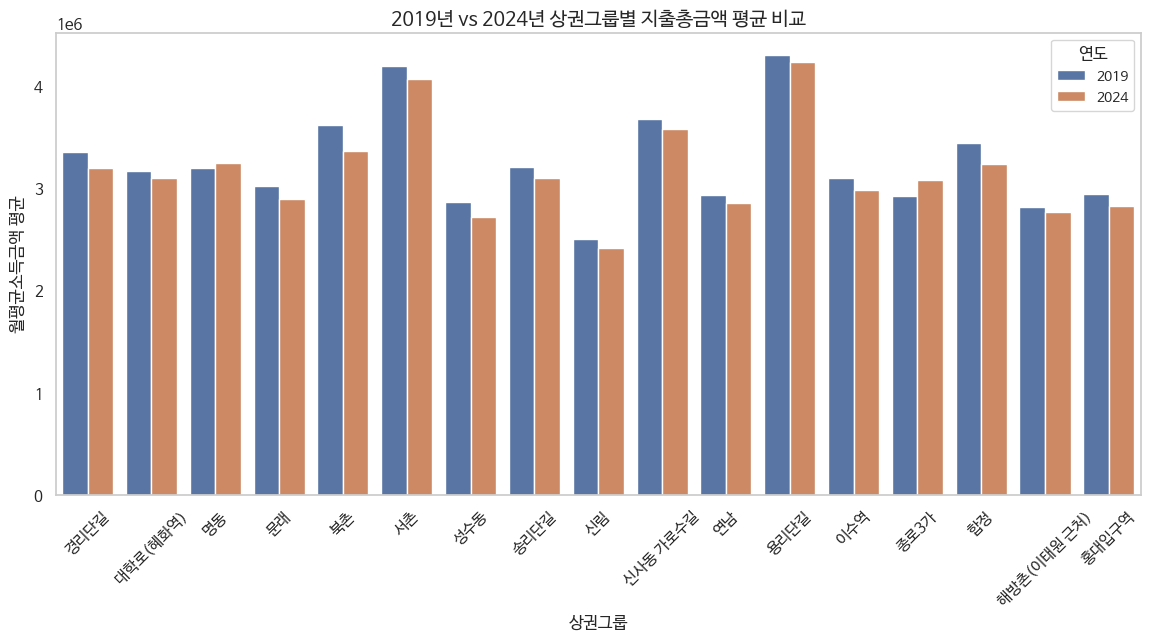

In [27]:
plot_comparison(gen, '월평균소득금액')

## 결론

- 연도별 변화를 비교할 수 없다
  - 데이터 갱신이 되지 않았다
  - 24년에 값이 감소하는 것처럼 보이지만, 24년의 경우 1분기에서 3분기까지의 데이터만 있다
- 젠트리, 비젠트리, 기본상권지별로 월평균소득금액과 지출금액을 비교
  - 월평균소득금액: 비젠트리-젠트리가 소득금액이 기본상권지에 비해 높은 편
  - 지출총금액: 오히려 기본상권지가 가장 높은 편, 그리고 모든 ooo지출금액의 순위 및 양상 동일
- 따라서, 해당 데이터로는 젠트리피케이션 지역의 평균 소득 소비가 증가할 것이다라는 가설을 증명할 수 없다. 또한, 젠트리, 비젠트리, 기본상권 비교를 했을때 기본상권지보다 젠트리, 비젠트리 지역의 평균소득이 높긴 하나 비젠트리가 젠트리보다 약간더 평균 소득 소비가 높다.
- 유의미한 인사이트 도출이 어렵다고 판단... 더 좋은 아이디어 있으면 알려주세여ㅠㅠ
